In [2]:
from ipynb.fs.defs.cml_functions import *
from time import sleep
from datetime import datetime
from linetimer import CodeTimer
import numpy as np

In [38]:
def cml_analyse(path,plot_save_path='cm_analysis/',search_radius=2):
    name = os.path.basename(os.path.splitext(path)[0])
    data = open_cm_log(path)
    # STEP 1: Rough geographic selection 
    position_list = extract_json_positions(data)
    positions_city = get_points_within_window(position_list)
    # Second round
    median = np.median(positions_city,axis=0)
    p0 = get_points_in_circle(positions_city, median, radius_km=search_radius)

    #plt.plot(median[1],median[0],'xr',ms=20)
    #plt.plot(p0[:,1],p0[:,0],'.') #plot longitude, latitude
    #mplleaflet.display()
    # STEP 2: Filter points belonging to train
    p1,D1=filter_train(p0,n_next=5,crit_thr=2)
    # STEP 3: Sort out outliers within train by taking median of 3 neighboring points
    p1_avg,D1_avg = median_with_nearest(p1,D1,n=3)
    # STEP 4: Sort points
    p2,D2 = sort_points(p1_avg,D1_avg)
    # STEP 5: Snap points to road
    #match0NoLoop,match0Unique = osrm_match(p2[:,:])
    
    if plot_save_path:
        # Create result plot
        plt.plot(positions_city[:,1],positions_city[:,0],'b.')
        plt.plot(p0[:,1],p0[:,0], 'xk')
        plt.plot(p2[:,1],p2[:,0], 'ok')
        # print('With loops:',getPathLength(match0Unique))
        # print('Loops removed:',getPathLength(match0NoLoop))
        #plt.plot(match0Unique[:,1],match0Unique[:,0],'b-')
        #plt.plot(match0NoLoop[:,1],match0NoLoop[:,0],'r-',linewidth=3)
        #mplleaflet.display(fig=f)
        mplleaflet_update(path=os.path.join(plot_save_path,name+'.html'))
    results = dict()
    results['p0'] = p0
    results['p1'] = p1
    results['p1_avg'] = p1_avg
    results['p2'] = p2
    results['distances2'] = np.diagonal(D2,offset=1)
    results['trivial_length'] = getPathLength(p2)
    if len(results['distances2'])>1:
        cumsum=np.cumsum(results['distances2'])
        idx=np.argmax(cumsum>results['trivial_length']/2)
        fLarger=cumsum[idx]/results['trivial_length']-0.5
        fSmaller=0.5-cumsum[idx-1]/results['trivial_length']
        center=np.sum([results['p2'][idx-1]*fSmaller,results['p2'][idx]*fLarger],axis=0)/(fLarger+fSmaller)
    else:
        center = p2[0]
    results['trivial_center'] = center
    results['name'] = name
    results['date'] = datetime.strptime(os.path.splitext(name)[0],'%Y%m%d_%H%M%S')
    #results['osmr_length'] = getPathLength(match0NoLoop)
    return results

#cml_analyse('cm_logs/20220624_210255.txt')
#results = cml_analyse('cm_logs/20220624_203957.txt')
with CodeTimer('All'):
    results = cml_analyse('cm_logs/20220624_215158.txt',plot_save_path='')

Code block 'All' took: 49.38630 ms


0
100
200
300
400
500
600
700
800
900
1000
1100
1200


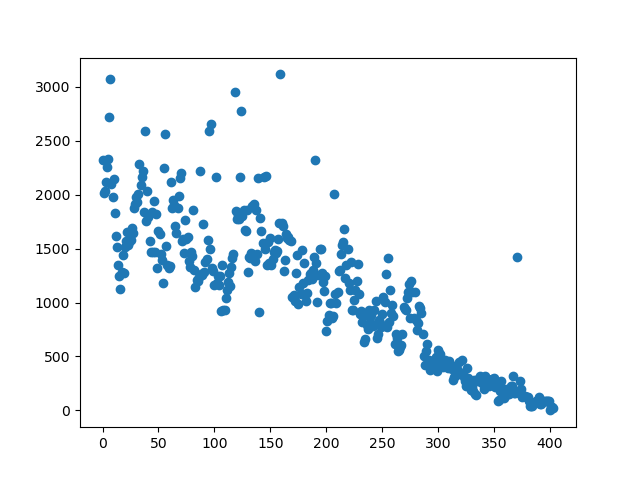

In [43]:
results_all = dict()
for ii,entry in enumerate(os.scandir('cm_logs')):
    if ii%3==0:
        if entry.path.endswith(".txt"):
            #print(entry.path)
            result = cml_analyse(entry.path,plot_save_path='')
            for k in result:
                if k not in results_all:
                    results_all[k] = []
                results_all[k].append(result[k])
            #sleep(1)
    if ii%100==0:
        print(ii)
results_all['trivial_center'] = np.array(results_all['trivial_center'])
%matplotlib widget
#plt.figure(figsize=(20,10))
plt.plot(results_all['trivial_length'],'o')

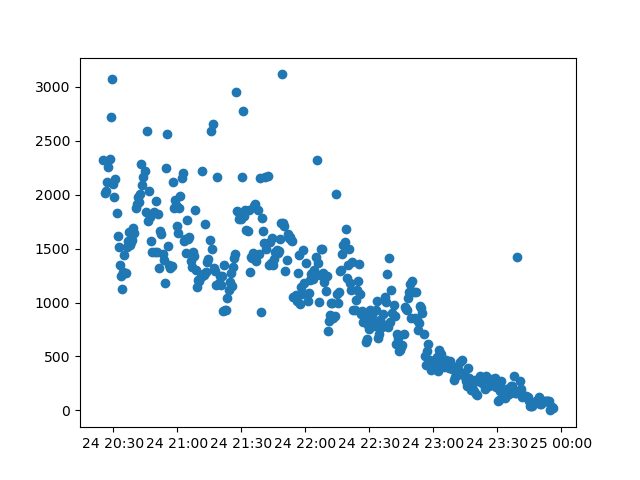

In [44]:
%matplotlib widget
#plt.figure(figsize=(20,10))
plt.plot(results_all['date'],results_all['trivial_length'],'o')

In [45]:
idx = 89;
print(idx,results_all['name'][idx],results_all['trivial_length'][idx])

89 20220624_211242 1250.7077087279642


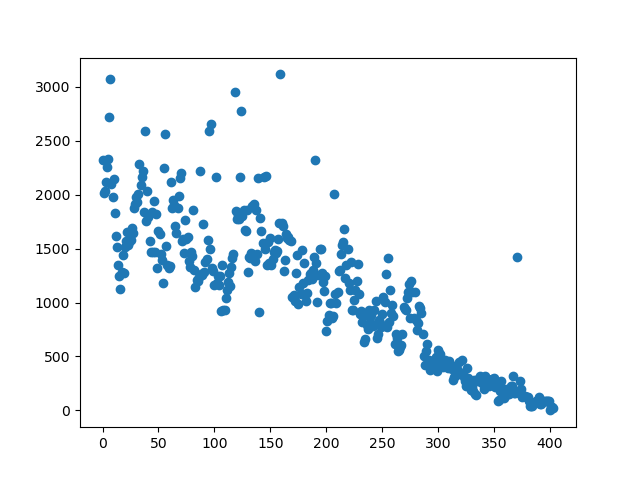

In [46]:
%matplotlib widget
#plt.figure(figsize=(20,10))
plt.plot(results_all['trivial_length'],'o')

In [47]:
f=plt.figure(figsize=(6,6))
plt.plot(results_all['trivial_center'][:,1],results_all['trivial_center'][:,0],'ok')
mplleaflet.display(fig=f)

C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")
